In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

### Goal
- How can we effectively invest in the school system to improve student learning in a way that is maximally efficient
- Build regression models that predict the performance of students based on the given features
- Combine proficiency by test scores as a quantitative way to measure success in school (objective measure, no response bias)
- Find out which features have the highest sensitivity, iow greatest impact on proficiency
- If we can predict the proficiency based on these factors, we can figure out which factors will impact a students performance the most and get the most out of the investment

In [2]:
raw_data=pd.read_excel('../../shared_data_read_only/NYCSchoolsData/NYC Schools -2021 Hackathon.xlsx')
raw_data.head()

,Adjusted Grade,New?,Other Location Code in LCGMS,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),...,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency
0,NaN,NaN,NaN,P.S. 015 ROBERTO CLEMENTE,310100010015,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",...,Exceeding Target,0.91,Exceeding Target,0.85,Meeting Target,0.94,Exceeding Target,Approaching Target,2.14,2.17
1,NaN,NaN,NaN,P.S. 019 ASHER LEVY,310100010019,01M019,1,40.729892,-73.984231,"185 1ST AVE NEW YORK, NY 10003",...,NaN,0.90,Exceeding Target,0.86,Meeting Target,0.94,Meeting Target,Exceeding Target,2.63,2.98
2,NaN,NaN,NaN,P.S. 020 ANNA SILVER,310100010020,01M020,1,40.721274,-73.986315,"166 ESSEX ST NEW YORK, NY 10002",...,Approaching Target,0.61,Not Meeting Target,0.80,Approaching Target,0.79,Not Meeting Target,Approaching Target,2.39,2.54
3,NaN,NaN,NaN,P.S. 034 FRANKLIN D. ROOSEVELT,310100010034,01M034,1,40.726147,-73.975043,"730 E 12TH ST NEW YORK, NY 10009",...,Meeting Target,0.73,Approaching Target,0.89,Meeting Target,0.88,Meeting Target,Exceeding Target,2.48,2.47
4,NaN,NaN,NaN,THE STAR ACADEMY - P.S.63,310100010063,01M063,1,40.724404,-73.986360,"121 E 3RD ST NEW YORK, NY 10009",...,Meeting Target,0.81,Meeting Target,0.89,Meeting Target,0.93,Meeting Target,Meeting Target,2.38,2.54


In [3]:
# Broad feature selection
X = raw_data.iloc[:,16:-2]
# Regression output
y = raw_data.iloc[:,-2:].sum(axis=1)

# Concat new metric to dataframe
schools = pd.concat([X, y], axis=1)
schools.rename(columns={0:'Combined Proficiency'}, inplace=True)

## Clean data

# Map rating to a score
rating = {'Not Meeting Target': 0, 'Approaching Target': 1, 'Meeting Target': 2, 'Exceeding Target': 3}
qual_rating_cols = ['Rigorous Instruction Rating'
                    , 'Collaborative Teachers Rating'
                    , 'Supportive Environment Rating'
                    , 'Effective School Leadership Rating'
                    , 'Strong Family-Community Ties Rating'
                    , 'Trust Rating'
                    , 'Student Achievement Rating']

schools[qual_rating_cols] = schools[qual_rating_cols].replace(rating)

# Drop NA values
print('With nan:',schools.shape)
schools = schools.dropna()

print('Without nan:', schools.shape)
schools.head()

With nan: (1272, 18)
Without nan: (795, 18)


,Economic Need Index,School Income Estimate,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Combined Proficiency
0,0.919,31141.72,0.94,0.18,0.89,2.0,0.94,2.0,0.86,3.0,0.91,3.0,0.85,2.0,0.94,3.0,1.0,4.31
2,0.744,44342.61,0.94,0.20,0.87,2.0,0.77,2.0,0.82,1.0,0.61,0.0,0.80,1.0,0.79,0.0,1.0,4.93
3,0.860,31454.00,0.92,0.28,0.85,1.0,0.78,2.0,0.82,2.0,0.73,1.0,0.89,2.0,0.88,2.0,3.0,4.95
4,0.730,46435.59,0.93,0.23,0.90,2.0,0.88,2.0,0.87,2.0,0.81,2.0,0.89,2.0,0.93,2.0,2.0,4.92
5,0.858,39415.45,0.92,0.33,0.93,2.0,0.99,3.0,0.95,3.0,0.91,3.0,0.88,2.0,0.97,3.0,2.0,4.77


In [4]:
## Split the data into training and testing

# Percent split between training and testing (80:20, 75:25, etc.)
tt_split = .2

pct = 1 - tt_split
train_data = schools.sample(frac=pct, random_state=100)#.reset_index(drop=True)
test_data = schools.drop(train_data.index).sample(frac=1, random_state=100).reset_index(drop=True)

# Scale the data for better training
def transform(train_data, test_data, scale_X, scale_y):
    train_vals = train_data.values
    test_vals = test_data.values

    X_train = scale_X.fit_transform(train_vals[:,:-1])
    y_train = scale_y.fit_transform(train_vals[:,-1].reshape(-1, 1))

    X_test = scale_X.transform(test_vals[:,:-1])
    y_test = scale_y.transform(test_vals[:,-1].reshape(-1, 1))

    train = feature_label_join(X_train, y_train)
    test = feature_label_join(X_test, y_test)

    return train, test, scale_X, scale_y

def feature_label_join(X, y):
    df = pd.DataFrame(np.concatenate([X,y], axis=1))
    return df

train_data, test_data, sx, sy = transform(train_data, test_data, MinMaxScaler(), StandardScaler())

In [5]:
X_train = train_data.values[:,:-1]
y_train = train_data.values[:,-1]

X_test = test_data.values[:,:-1]
y_test = test_data.values[:,-1]

In [6]:
svr = svm.SVR(kernel='linear', degree=2)

# estimate most important features using recursive feature estimation
rfe = RFE(svr).fit(X_train, y_train)
feature_ranks = rfe.ranking_
print(f'Estimated score: {rfe.score(X_test,y_test)}')

important_features = []
for idx, rank in enumerate(feature_ranks):
    if rank == 1:
        important_features.append(idx)
        
print(f'feature rankings: {feature_ranks}')
print(important_features)

Estimated score: 0.8246260642542234
feature rankings: [ 1  1  1  1  8  1  1  4  2  5  1 10  9  6  3  7  1]
[0, 1, 2, 3, 5, 6, 10, 16]


In [7]:
feature_names = schools.iloc[:,important_features].columns.values
print(f'Most important factors: {feature_names}')

# With the features of 'Rigorous Instruction Rating' and 'Student Achievement Rating', these inputs are rigid
# between 1 and 4 so it doesnt help much to visualize correlations. Further, student achievement rating is a
# bit redundant to the performance metric we are predicting of proficiency. Let's drop those columns and narrow
# down to the main five, while also recognizing the impact of those features.
important_features = np.delete(important_features, [4,-1])

X_train2 = X_train[:,important_features]
X_test2 = X_test[:,important_features]

Most important factors: ['Economic Need Index' 'School Income Estimate' 'Student Attendance Rate'
 'Percent of Students Chronically Absent' 'Rigorous Instruction Rating'
 'Collaborative Teachers %' 'Effective School Leadership %'
 'Student Achievement Rating']


In [8]:
# Hyperparameter search to optimize model
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[.1,1,10,100,1000],'gamma': [1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8],'epsilon':[0.1,0.2,0.3,0.4,.5]}
clf = GridSearchCV(svm.SVR(), parameters)
clf.fit(X_train2,y_train)
print(clf.best_params_)

{'C': 100, 'epsilon': 0.3, 'gamma': 0.001, 'kernel': 'linear'}


In [9]:
# Can use this model to predict student proficiency in combined MATH + ELA score
# based on most important factors. As we can see, dropping the redundant rating
# predictably lowered the performance of the model
svr = svm.SVR(kernel='linear', epsilon=.3, gamma=.0001, C=100)
svr.fit(X_train2, y_train)
svr.score(X_test2,y_test)

0.7306140135146787

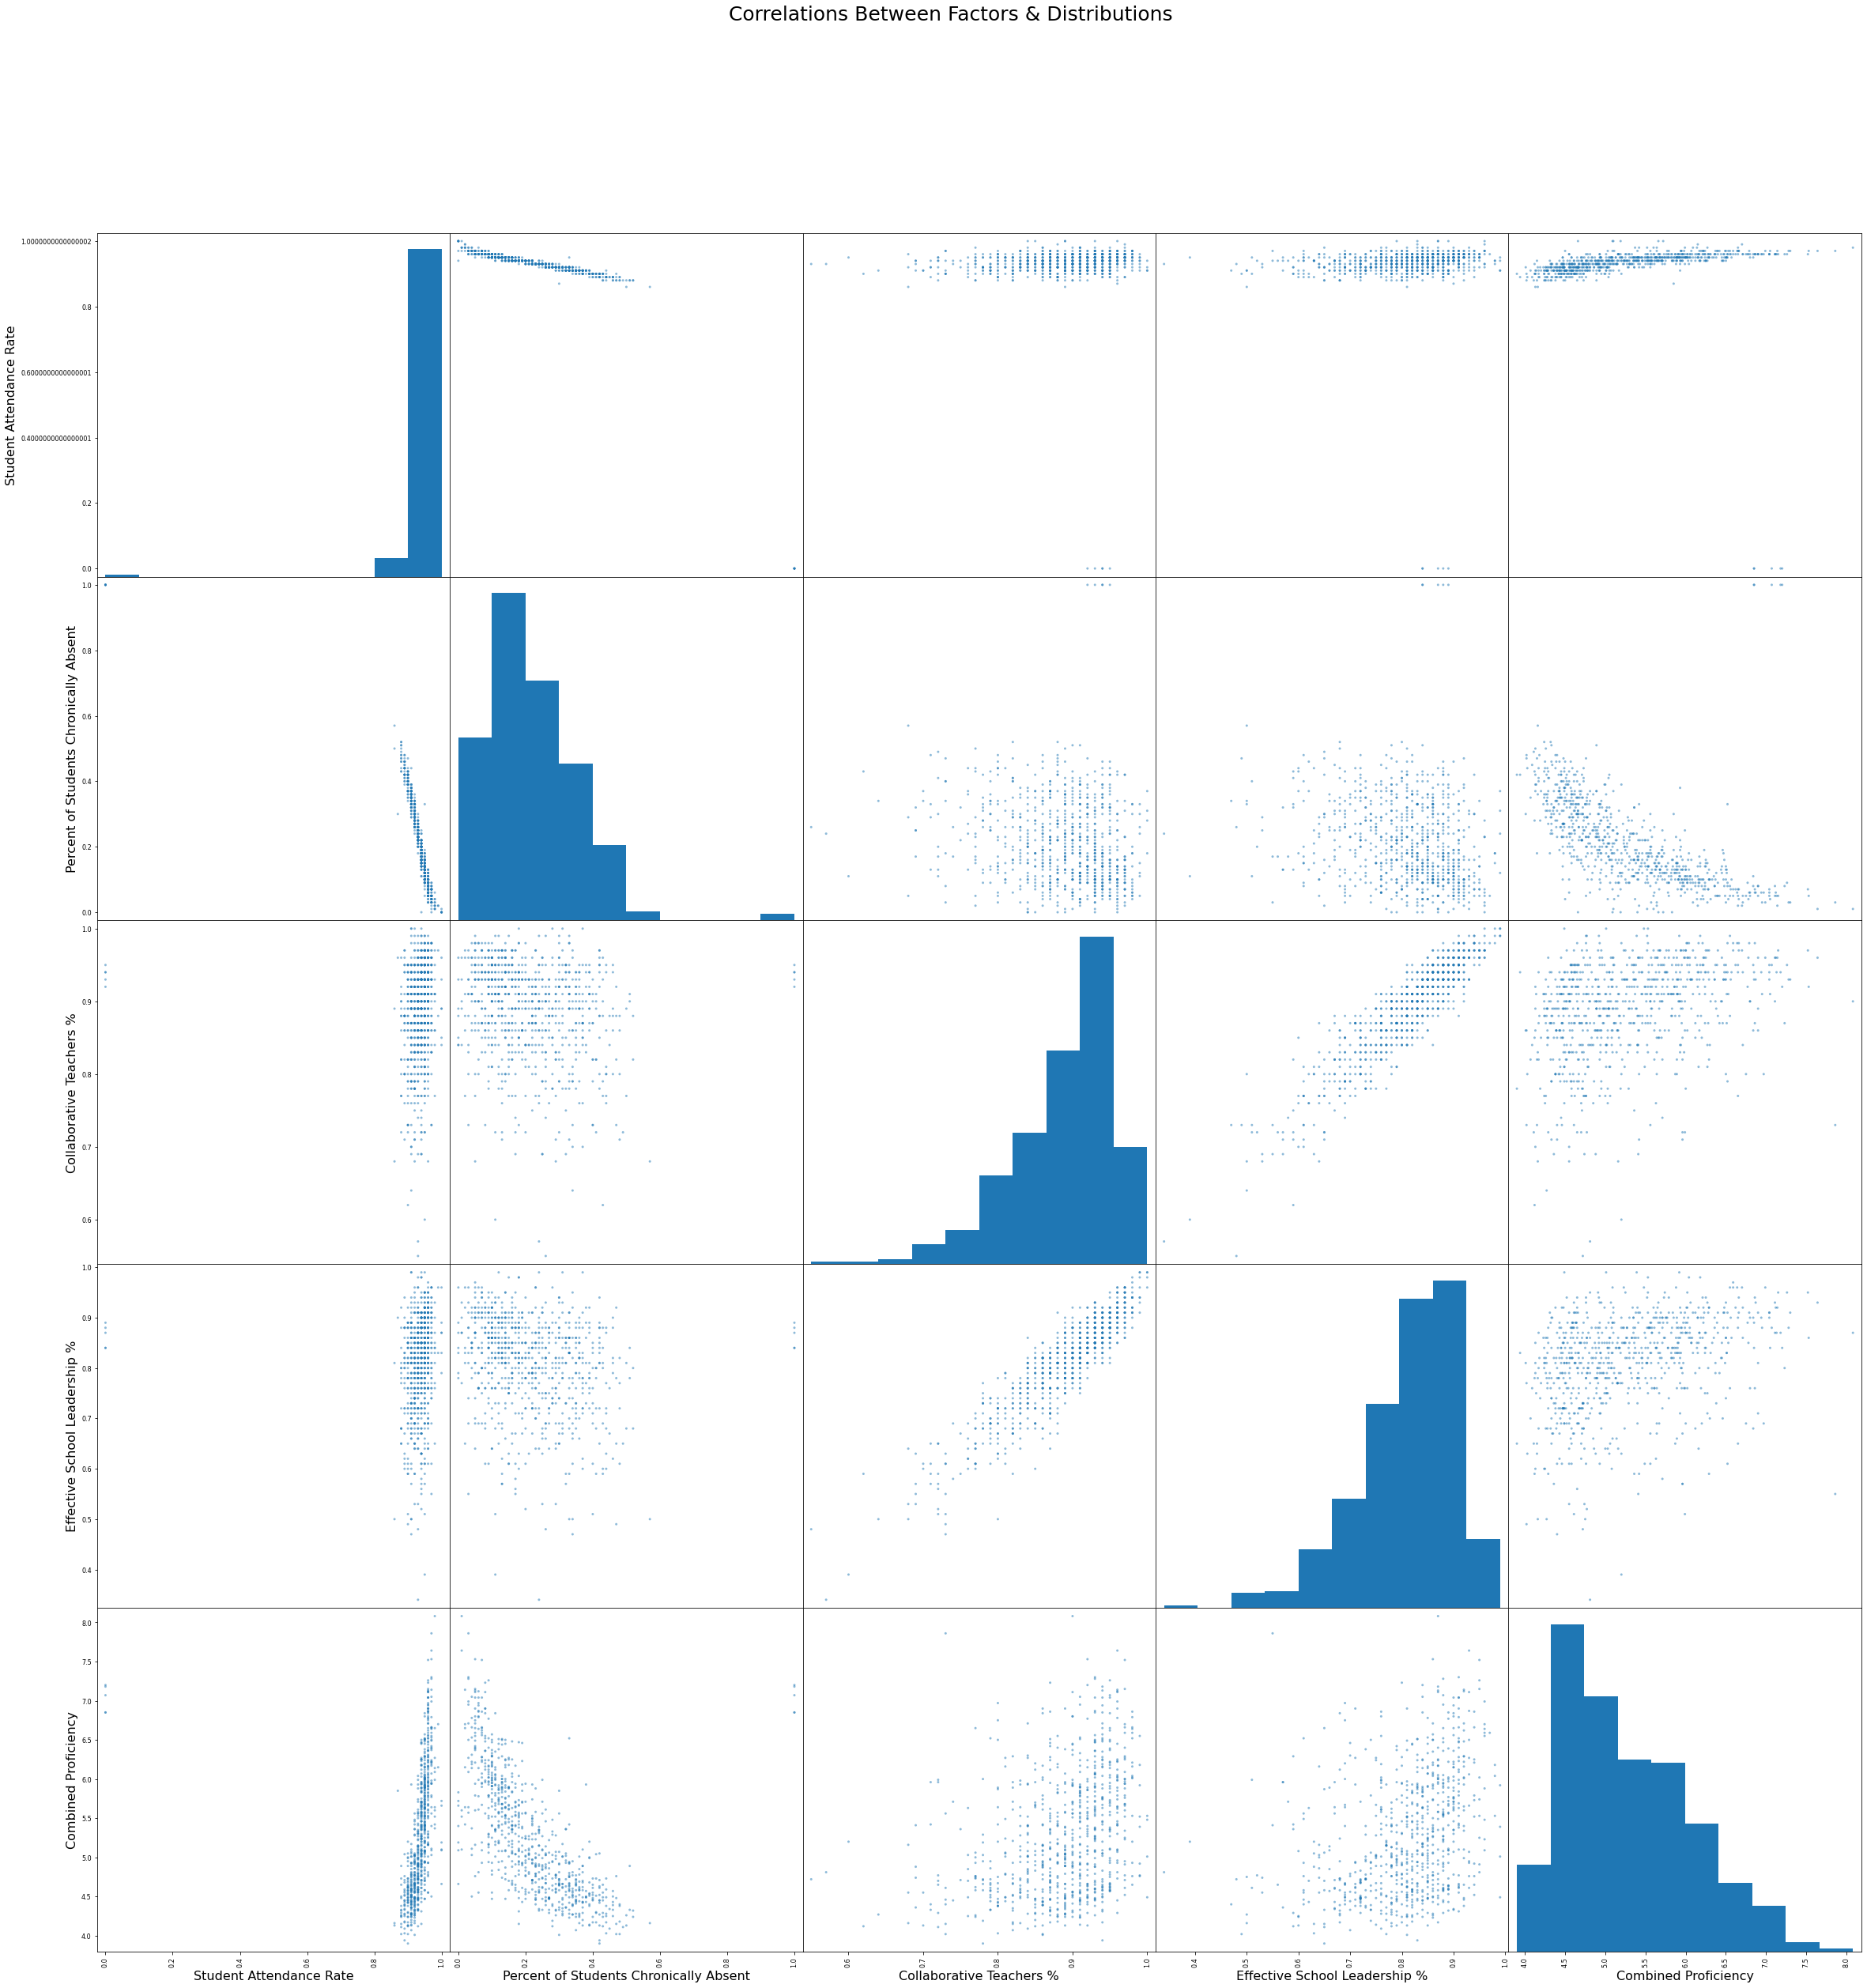

In [10]:
important_features = np.delete(important_features, [0,1])
correlations = schools.iloc[:,important_features].join(schools.iloc[:,-1])
scatter = pd.plotting.scatter_matrix(correlations, figsize=(40,40))
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 20)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 16)
plt.suptitle('Correlations Between Factors & Distributions', fontsize=25)
plt.savefig('../visualizations/scatter_matrix.pdf')
plt.show()